In [1]:
import metpy.interpolate
import numpy as np
import xarray as xr
import cf_xarray


In [2]:
import xcdat
import xgcm

One vertical interplation case is to convert from hyrid sigma model vertical coordinate (https://www.cesm.ucar.edu/models/atm-cam/docs/usersguide/node25.html) to pressure coordinate.
This note book testing three ways for this operation:

1. Call `interp_hybrid_to_pressure` function from GeoCAT: https://github.com/NCAR/geocat-comp/blob/0263d2d77ab22a6be4d1d3f16d5bfcfc68057364/src/geocat/comp/interp_hybrid_to_pressure.py which wraps metpy's vertical interp function.

2. Call metpy's vertical interp function directly https://github.com/Unidata/MetPy/blob/main/src/metpy/interpolate/one_dimension.py:

3. Use xgcm's vertical coordinates transforming: https://xgcm.readthedocs.io/en/latest/transform.html

Data for testing are available at /p/user_pub/e3sm/zhang40/xcdat_test_e3sm:

ds = xr.open_dataset('T_185001.nc') # Data includes one time step
ds = xr.open_dataset('T_185001_201312.nc') # # Data includes longer time for performance tests

Next Cell copied from GeoCAT with minor change in _pressure_from_hybrid function.

In [3]:

__pres_lev_mandatory__ = np.array([
    1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10,
    7, 5, 3, 2, 1
]).astype(np.float32)  # Mandatory pressure levels (mb)
__pres_lev_mandatory__ = __pres_lev_mandatory__ * 100.0  # Convert mb to Pa


def _pressure_from_hybrid(psfc, hya, hyb, p0=100000.):
    """
    Calculate pressure at the hybrid levels
    """
    pressure = hya * p0 + hyb * psfc
    # Temporarily added by Jill Zhang
    pressure = pressure.transpose("time","lev","lat", "lon") # Note order of the pressure dims should match those in ds['T']
    return pressure
    ## This will be in Pa
    #return hya * p0 + hyb * psfc


def interp_hybrid_to_pressure(data,
                              ps,
                              hyam,
                              hybm,
                              p0=100000.,
                              new_levels=__pres_lev_mandatory__,
                              lev_dim=None,
                              method='linear'):
    """
    Interpolate data from hybrid-sigma levels to isobaric levels.
    Notes
    -----
    ACKNOWLEDGEMENT: We'd like to thank to Brian Medeiros (https://github.com/brianpm), Matthew Long
    (https://github.com/matt-long), and Deepak Cherian (https://github.com/dcherian) at NCAR for their
    great contributions since the code implemented here is mostly based on their work.
    Parameters
    ----------
    data : xarray.DataArray
        Multidimensional data array, which holds hybrid-sigma levels and has a `lev_dim` coordinate.
    ps : xarray.DataArray
        A multi-dimensional array of surface pressures (Pa), same time/space shape as data.
    hyam, hybm : xarray.DataArray
        One-dimensional arrays containing the hybrid A and B coefficients. Must have the same
        dimension size as the `lev_dim` dimension of data.
    p0 :
        Scalar numeric value equal to surface reference pressure (Pa).
    new_levels : np.ndarray
        A one-dimensional array of output pressure levels (Pa). If not given, the mandatory
        list of 21 pressure levels is used.
    lev_dim : str
        String that is the name of level dimension in data. Defaults to "lev".
    method : str
        String that is the interpolation method; can be either "linear" or "log". Defaults to "linear".
    """

    # Determine the level dimension and then the interpolation axis
    if lev_dim is None:
        try:
            lev_dim = data.cf["vertical"].name
        except Exception:
            raise ValueError(
                "Unable to determine vertical dimension name. Please specify the name via `lev_dim` argument.'"
            )

    interp_axis = data.dims.index(lev_dim)
    print(interp_axis)

    # Calculate pressure levels at the hybrid levels
    pressure = _pressure_from_hybrid(ps, hyam, hybm, p0)  # Pa
    

    # Define interpolation function
    if method == 'linear':
        func_interpolate = metpy.interpolate.interpolate_1d
    elif method == 'log':
        func_interpolate = metpy.interpolate.log_interpolate_1d
    else:
        raise ValueError(f'Unknown interpolation method: {method}. '
                         f'Supported methods are: "log" and "linear".')

    def _vertical_remap(data, pressure):
        """
        Define interpolation function.
        """

        return func_interpolate(new_levels, pressure, data, axis=interp_axis)

    # Apply vertical interpolation
    # Apply Dask parallelization with xarray.apply_ufunc
    output = xr.apply_ufunc(
        _vertical_remap,
        data,
        pressure,
        exclude_dims=set((lev_dim,)),  # Set dimensions allowed to change size
        input_core_dims=[[lev_dim], [lev_dim]],  # Set core dimensions
        output_core_dims=[["plev"]],  # Specify output dimensions
        vectorize=True,  # loop over non-core dims
        dask="parallelized",  # Dask parallelization
        output_dtypes=[data.dtype],
        dask_gufunc_kwargs={"output_sizes": {
            "plev": len(new_levels)
        }},
    )

    # Set output dims and coords
    dims = ["plev"
           ] + [data.dims[i] for i in range(data.ndim) if i != interp_axis]

    coords = {}
    for (k, v) in data.coords.items():
        if k != lev_dim:
            coords.update({k: v})
        else:
            coords.update({"plev": new_levels})

    output = output.transpose(*dims).assign_coords(coords)

    return output

In [4]:
ds = xr.open_dataset('T_185001.nc') # Data includes one time step

In [5]:
#ds = xr.open_dataset('T_185001_201312.nc') # Data includes longer time for performance tests

1. Call `interp_hybrid_to_pressure` function from GeoCAT: https://github.com/NCAR/geocat-comp/blob/0263d2d77ab22a6be4d1d3f16d5bfcfc68057364/src/geocat/comp/interp_hybrid_to_pressure.py which wraps metpy's vertical interp function.


In [6]:
ds_p = interp_hybrid_to_pressure(ds['T'], ds['PS'], ds['hyam'],ds['hybm'],p0=100000.,new_levels=np.array([92500,800]),lev_dim="lev",method='linear')

1


AxisError: axis 1 is out of bounds for array of dimension 1


2. Call metpy's vertical interp function directly https://github.com/Unidata/MetPy/blob/main/src/metpy/interpolate/one_dimension.py:



In [7]:
interp_axis = ds["T"].dims.index("lev")

In [8]:
print("interp_axis",interp_axis)

interp_axis 1


In [9]:
pressure = _pressure_from_hybrid(ds['PS'], ds['hyam'],ds['hybm'],p0=100000)  # Pa and with dim order (lev, time, lat, lon)

In [10]:
pressure = pressure.transpose("time","lev","lat", "lon") # Note order of the pressure dims should match those in ds['T']

In [11]:
interp_axis2 = pressure.dims.index("lev")

In [12]:
print(interp_axis, interp_axis2)

1 1


In [13]:
metpy.interpolate.interpolate_1d(np.array([92500, 80000]), pressure, ds['T'], axis=interp_axis)

TypeError: no implementation found for 'numpy.apply_along_axis' on types that implement __array_function__: [<class 'pint.quantity.build_quantity_class.<locals>.Quantity'>]

3. Use xgcm's vertical coordinates transforming: https://xgcm.readthedocs.io/en/latest/transform.html

In [14]:
from xgcm import Grid

In [15]:
ds['pressure'] = pressure

In [16]:
# First create an xgcm grid object
grid = Grid(ds, coords={'lev': {'center':'lev'}}, periodic=False)


In [17]:
# define the target values in density, linearly spaced
target_lev = np.array([80000, 92500])

# and transform
t_transformed = grid.transform(ds['T'], 'lev', target_lev, target_data=ds['pressure'])


/Users/zhang40/miniconda3/envs/xcdat_test_dev/lib/python3.9/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [18]:
t_transformed.shape

(1, 129, 256, 2)

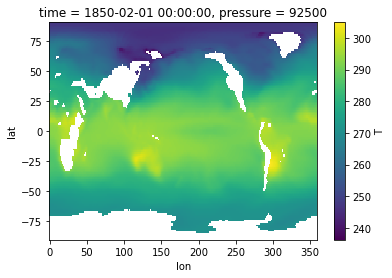

In [19]:
t_transformed[0,:,:,1].plot()